### Baseline NN and FT ReLU replacement

In [ ]:
# Experiment loop:
# 1) Train baseline once
# 2) Freeze weights (by copying state_dict)
# 3) Replace ReLU with FT-ReLU
# 4) Sweep one noise type at a time (no cross-interactions since they're worse together)

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from threeSpiral import (
    make_3_spirals, train, accuracy,
    MLP, FaultTolerantReLU, FTReluConfig, replace_relu_with_ftrelu,
)

device = "cpu"
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)


# Data -------------------------

X, y = make_3_spirals(n_per_class=600, noise=0.25, seed=seed)
idx = np.random.permutation(len(X))
split = int(0.8 * len(X))
tr, te = idx[:split], idx[split:]

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[tr]), torch.from_numpy(y[tr])),
    batch_size=256, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[te]), torch.from_numpy(y[te])),
    batch_size=256, shuffle=False
)


# Train baseline ONCE -------------------------

baseline = MLP(in_dim=2, hidden=32, out_dim=3)
train(baseline, train_loader, test_loader, device, epochs=1000, lr=1e-3)
baseline_acc = accuracy(baseline, test_loader, device)
print(f"\nBaseline test accuracy: {baseline_acc:.4f}")

baseline_state = {k: v.detach().cpu().clone() for k, v in baseline.state_dict().items()}


# FT config -------------------------

x_min, x_max = -26.0, 14.0
S = 200  # use larger value for final plots; 100 is faster for sweeps

# Define sweeps
sweeps = {
    # "sigma_trig":  [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2],
    # "sigma_score": [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2],
    # "p_syn":       [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2],
    # "sigma_trig":  [0.0],
    # "sigma_score": [0.0],
    # "p_syn":       [0.0],
    # sigma_phase is known to be problematic in this architecture; included only as a demonstration
    "sigma_phase": [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01],
}

results = {k: [] for k in sweeps.keys()}

def eval_ft_with_noise(noise_name: str, noise_val: float) -> float:
    model = MLP(in_dim=2, hidden=32, out_dim=3)
    model.load_state_dict(baseline_state)

    cfg = FTReluConfig(
        x_min=x_min, x_max=x_max, S=S,
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p_syn=0.0,
    )

    # set exactly one noise knob
    setattr(cfg, noise_name, float(noise_val))

    replace_relu_with_ftrelu(model, FaultTolerantReLU(cfg))
    return accuracy(model, test_loader, device)


# Run one noise at a time

for noise_name, vals in sweeps.items():
    print(f"\n=== Sweeping {noise_name} (others = 0) ===")
    for v in vals:
        acc = eval_ft_with_noise(noise_name, v)
        results[noise_name].append((v, acc))
        print(f"{noise_name}={v:.3e} -> FT acc={acc:.4f} | baseline={baseline_acc:.4f}")


epoch    1 | train acc 0.337 | test acc 0.331
epoch  100 | train acc 0.472 | test acc 0.431
epoch  200 | train acc 0.777 | test acc 0.711
epoch  300 | train acc 0.899 | test acc 0.861
epoch  400 | train acc 0.950 | test acc 0.925
epoch  500 | train acc 0.969 | test acc 0.958
epoch  600 | train acc 0.976 | test acc 0.964
epoch  700 | train acc 0.978 | test acc 0.967
epoch  800 | train acc 0.981 | test acc 0.975
epoch  900 | train acc 0.985 | test acc 0.978
epoch 1000 | train acc 0.985 | test acc 0.975

Baseline test accuracy: 0.9750

=== Sweeping sigma_phase (others = 0) ===
sigma_phase=0.000e+00 -> FT acc=0.9528 | baseline=0.9750
sigma_phase=1.000e-03 -> FT acc=0.9667 | baseline=0.9750
sigma_phase=2.000e-03 -> FT acc=0.9472 | baseline=0.9750
sigma_phase=3.000e-03 -> FT acc=0.9194 | baseline=0.9750
sigma_phase=4.000e-03 -> FT acc=0.8750 | baseline=0.9750
sigma_phase=5.000e-03 -> FT acc=0.8583 | baseline=0.9750
sigma_phase=6.000e-03 -> FT acc=0.7778 | baseline=0.9750
sigma_phase=7.000e-0

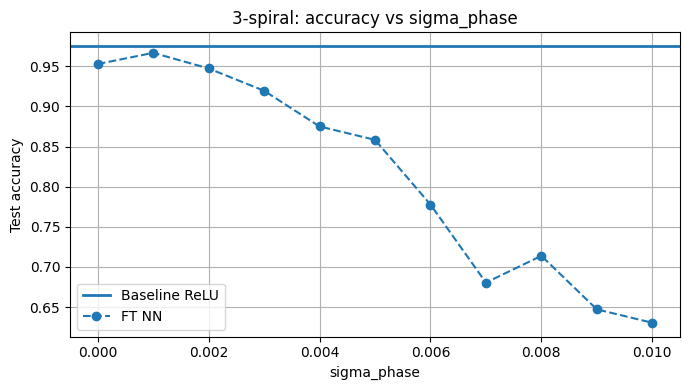

In [ ]:
import matplotlib.pyplot as plt

noise_order = ["sigma_trig", "sigma_score", "p_syn", "sigma_phase"]

for noise_name in noise_order:
    if noise_name not in results or len(results[noise_name]) == 0:
        continue

    xs = [v for v, a in results[noise_name]]
    ys = [a for v, a in results[noise_name]]

    plt.figure(figsize=(7,4))
    plt.axhline(baseline_acc, linewidth=2, label="Baseline ReLU")

    if noise_name == "sigma_phase":
        plt.plot(xs, ys, "o--", label="FT NN")
        # plt.xscale("log")
    else:
        plt.plot(xs, ys, "o--", label="FT NN")

    plt.xlabel(noise_name)
    plt.ylabel("Test accuracy")
    plt.title(f"3-spiral: accuracy vs {noise_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Cross-sweeping the noise types to make heatmaps


=== Computing heatmap for (x=sigma_trig, y=sigma_score) ===
sigma_score=0, sigma_trig=0 -> acc=0.8833
sigma_score=0, sigma_trig=0.02 -> acc=0.9056
sigma_score=0, sigma_trig=0.04 -> acc=0.8333
sigma_score=0, sigma_trig=0.06 -> acc=0.8000
sigma_score=0, sigma_trig=0.08 -> acc=0.7972
sigma_score=0, sigma_trig=0.1 -> acc=0.6639
sigma_score=0.02, sigma_trig=0 -> acc=0.7139
sigma_score=0.02, sigma_trig=0.02 -> acc=0.7083
sigma_score=0.02, sigma_trig=0.04 -> acc=0.7250
sigma_score=0.02, sigma_trig=0.06 -> acc=0.6583
sigma_score=0.02, sigma_trig=0.08 -> acc=0.6861
sigma_score=0.02, sigma_trig=0.1 -> acc=0.6389
sigma_score=0.04, sigma_trig=0 -> acc=0.6028
sigma_score=0.04, sigma_trig=0.02 -> acc=0.5528
sigma_score=0.04, sigma_trig=0.04 -> acc=0.5806
sigma_score=0.04, sigma_trig=0.06 -> acc=0.5833
sigma_score=0.04, sigma_trig=0.08 -> acc=0.5778
sigma_score=0.04, sigma_trig=0.1 -> acc=0.5472
sigma_score=0.06, sigma_trig=0 -> acc=0.5306
sigma_score=0.06, sigma_trig=0.02 -> acc=0.5028
sigma_score=

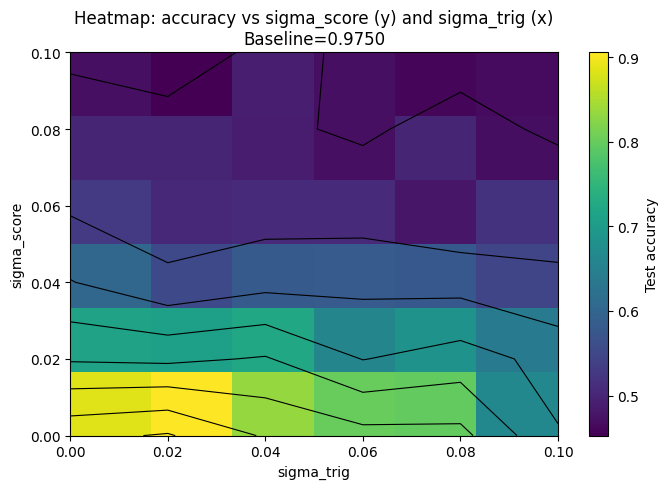


=== Computing heatmap for (x=sigma_trig, y=p_syn) ===
p_syn=0, sigma_trig=0 -> acc=0.8833
p_syn=0, sigma_trig=0.02 -> acc=0.8778
p_syn=0, sigma_trig=0.04 -> acc=0.8528
p_syn=0, sigma_trig=0.06 -> acc=0.8222
p_syn=0, sigma_trig=0.08 -> acc=0.7389
p_syn=0, sigma_trig=0.1 -> acc=0.7111
p_syn=0.02, sigma_trig=0 -> acc=0.7250
p_syn=0.02, sigma_trig=0.02 -> acc=0.7056
p_syn=0.02, sigma_trig=0.04 -> acc=0.6639
p_syn=0.02, sigma_trig=0.06 -> acc=0.6111
p_syn=0.02, sigma_trig=0.08 -> acc=0.6361
p_syn=0.02, sigma_trig=0.1 -> acc=0.5944
p_syn=0.04, sigma_trig=0 -> acc=0.5500
p_syn=0.04, sigma_trig=0.02 -> acc=0.5806
p_syn=0.04, sigma_trig=0.04 -> acc=0.5750
p_syn=0.04, sigma_trig=0.06 -> acc=0.5639
p_syn=0.04, sigma_trig=0.08 -> acc=0.5278
p_syn=0.04, sigma_trig=0.1 -> acc=0.4722
p_syn=0.06, sigma_trig=0 -> acc=0.5333
p_syn=0.06, sigma_trig=0.02 -> acc=0.5167
p_syn=0.06, sigma_trig=0.04 -> acc=0.4639
p_syn=0.06, sigma_trig=0.06 -> acc=0.4694
p_syn=0.06, sigma_trig=0.08 -> acc=0.4694
p_syn=0.06, 

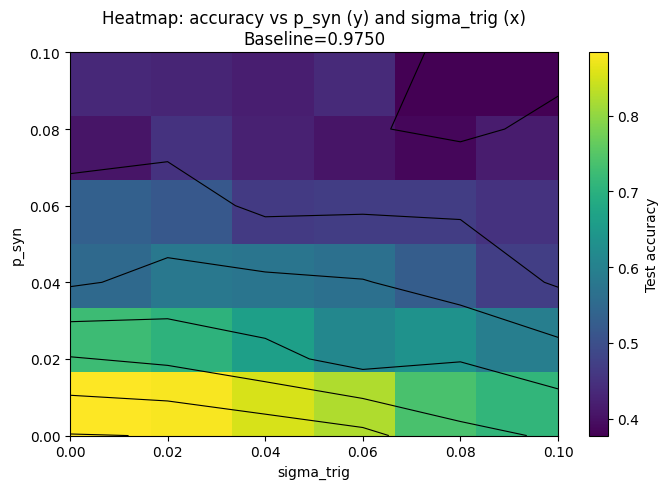


=== Computing heatmap for (x=sigma_score, y=p_syn) ===
p_syn=0, sigma_score=0 -> acc=0.8833
p_syn=0, sigma_score=0.02 -> acc=0.7194
p_syn=0, sigma_score=0.04 -> acc=0.6194
p_syn=0, sigma_score=0.06 -> acc=0.4917
p_syn=0, sigma_score=0.08 -> acc=0.4556
p_syn=0, sigma_score=0.1 -> acc=0.4389
p_syn=0.02, sigma_score=0 -> acc=0.6778
p_syn=0.02, sigma_score=0.02 -> acc=0.6250
p_syn=0.02, sigma_score=0.04 -> acc=0.5333
p_syn=0.02, sigma_score=0.06 -> acc=0.5250
p_syn=0.02, sigma_score=0.08 -> acc=0.4361
p_syn=0.02, sigma_score=0.1 -> acc=0.4639
p_syn=0.04, sigma_score=0 -> acc=0.5667
p_syn=0.04, sigma_score=0.02 -> acc=0.4750
p_syn=0.04, sigma_score=0.04 -> acc=0.4667
p_syn=0.04, sigma_score=0.06 -> acc=0.4500
p_syn=0.04, sigma_score=0.08 -> acc=0.4833
p_syn=0.04, sigma_score=0.1 -> acc=0.4000
p_syn=0.06, sigma_score=0 -> acc=0.4778
p_syn=0.06, sigma_score=0.02 -> acc=0.4528
p_syn=0.06, sigma_score=0.04 -> acc=0.4389
p_syn=0.06, sigma_score=0.06 -> acc=0.3972
p_syn=0.06, sigma_score=0.08 ->

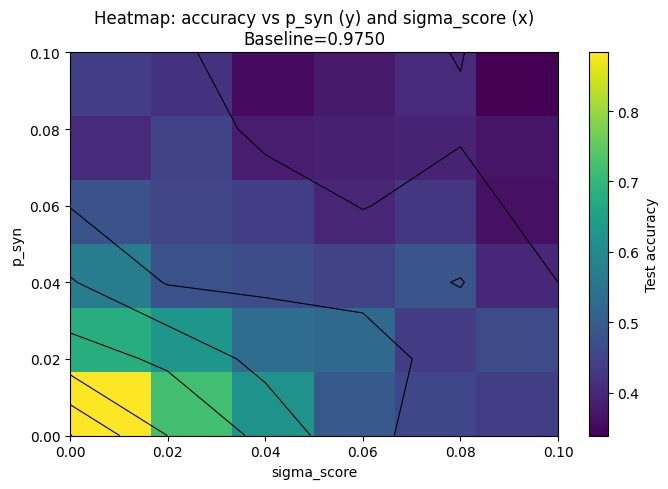

In [ ]:
# 3 "working" noise types (phase is problematic)
noise_types = ["sigma_trig", "sigma_score", "p_syn"]  # -> 3  heatmaps

vals = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10]

x_min, x_max = -26.0, 14.0
S = 101

def compute_heatmap(noise_x, noise_y, x_vals, y_vals):
    acc_grid = np.zeros((len(y_vals), len(x_vals)), dtype=float)

    for iy, vy in enumerate(y_vals):
        for ix, vx in enumerate(x_vals):
            model = MLP(in_dim=2, hidden=32, out_dim=3)
            model.load_state_dict(baseline.state_dict())

            cfg = FTReluConfig(
                x_min=x_min, x_max=x_max, S=S,
                sigma_phase=0.0, sigma_trig=0.0, sigma_score=0.0, p_syn=0.0
            )

            setattr(cfg, noise_x, float(vx))
            setattr(cfg, noise_y, float(vy))

            replace_relu_with_ftrelu(model, FaultTolerantReLU(cfg))
            acc = accuracy(model, test_loader, "cpu")
            acc_grid[iy, ix] = acc

            print(f"{noise_y}={vy:.3g}, {noise_x}={vx:.3g} -> acc={acc:.4f}")

    return acc_grid

def plot_heatmap(acc_grid, noise_x, noise_y, x_vals, y_vals, baseline_acc):
    plt.figure(figsize=(7,5))
    im = plt.imshow(
        acc_grid,
        origin="lower",
        aspect="auto",
        extent=[min(x_vals), max(x_vals), min(y_vals), max(y_vals)]
    )
    plt.colorbar(im, label="Test accuracy")

    plt.contour(
        np.linspace(min(x_vals), max(x_vals), len(x_vals)),
        np.linspace(min(y_vals), max(y_vals), len(y_vals)),
        acc_grid,
        colors="k",
        linewidths=0.8
    )

    plt.xlabel(noise_x)
    plt.ylabel(noise_y)
    plt.title(f"Heatmap: accuracy vs {noise_y} (y) and {noise_x} (x)\nBaseline={baseline_acc:.4f}")
    plt.tight_layout()
    plt.show()

pairs = [
    ("sigma_trig",  "sigma_score"),
    ("sigma_trig",  "p_syn"),
    ("sigma_score", "p_syn"),
]

heatmaps = {}

for noise_x, noise_y in pairs:
    print(f"\n=== Computing heatmap for (x={noise_x}, y={noise_y}) ===")
    grid = compute_heatmap(noise_x, noise_y, vals, vals)
    heatmaps[(noise_x, noise_y)] = grid
    plot_heatmap(grid, noise_x, noise_y, vals, vals, baseline_acc)

### Sweeping different redundancy levels (M)

epoch    1 | train acc 0.431 | test acc 0.431
epoch  120 | train acc 0.923 | test acc 0.925
epoch  240 | train acc 0.976 | test acc 0.980
epoch  360 | train acc 0.982 | test acc 0.986
epoch  480 | train acc 0.984 | test acc 0.988
epoch  600 | train acc 0.985 | test acc 0.988
epoch  720 | train acc 0.985 | test acc 0.988
epoch  840 | train acc 0.985 | test acc 0.988
epoch  960 | train acc 0.984 | test acc 0.987
epoch 1080 | train acc 0.985 | test acc 0.987
epoch 1200 | train acc 0.985 | test acc 0.987

Baseline test accuracy: 0.9872

M= 3 | acc=0.5083 | eps=0.49166667 | log(1/eps)=0.710
M= 4 | acc=0.8667 | eps=0.13333333 | log(1/eps)=2.015
M= 5 | acc=0.9411 | eps=0.05888889 | log(1/eps)=2.832
M= 6 | acc=0.9344 | eps=0.06555556 | log(1/eps)=2.725
M= 7 | acc=0.9389 | eps=0.06111111 | log(1/eps)=2.795
M= 8 | acc=0.9383 | eps=0.06166667 | log(1/eps)=2.786
M= 9 | acc=0.9589 | eps=0.04111111 | log(1/eps)=3.191
M=10 | acc=0.9667 | eps=0.03333333 | log(1/eps)=3.401
M=11 | acc=0.9717 | eps=0.028

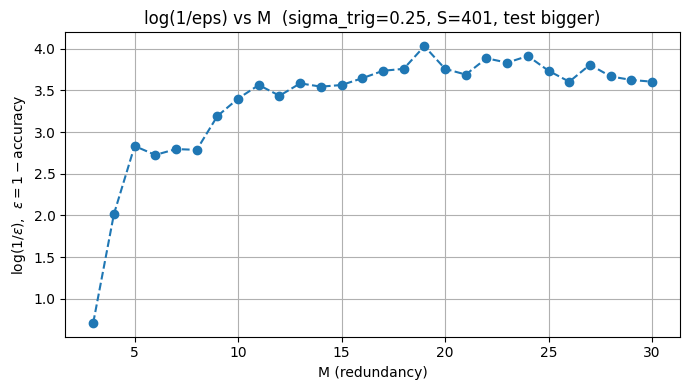

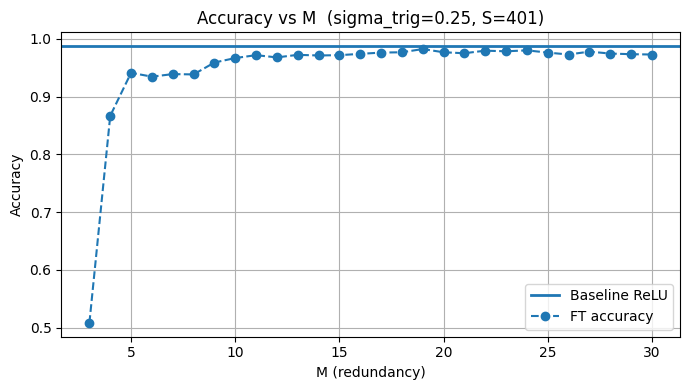

In [ ]:
# ---------- helpers ----------
def first_n_primes(n: int):
    primes = []
    cand = 2
    while len(primes) < n:
        ok = True
        for p in primes:
            if p*p > cand: break
            if cand % int(p) == 0:
                ok = False
                break
        if ok:
            primes.append(float(cand))
        cand += 1
    return primes

# ---------- settings ----------
device = "cpu"
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Make test set larger to resolve small eps
n_per_class = 3000      # bigger than before
noise_data  = 0.25

hidden = 32
epochs = 1200
lr = 1e-3

x_min, x_max = -26.0, 14.0
S = 401                 # use 2001 for final confirmation (slower)

# Increase noise (try 0.2–0.4)
sigma_trig_fixed  = 0.25
sigma_score_fixed = 0.0
p_syn_fixed       = 0.0
sigma_phase_fixed = 0.0

min_M, max_M = 3, 30
base_lambdas = first_n_primes(max_M)

# ---------- data ----------
X, y = make_3_spirals(n_per_class=n_per_class, noise=noise_data, seed=seed)
idx = np.random.permutation(len(X))
split = int(0.8 * len(X))
tr, te = idx[:split], idx[split:]

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[tr]), torch.from_numpy(y[tr])),
    batch_size=512, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[te]), torch.from_numpy(y[te])),
    batch_size=512, shuffle=False
)

# ---------- train baseline once ----------
baseline = MLP(in_dim=2, hidden=hidden, out_dim=3)
train(baseline, train_loader, test_loader, device, epochs=epochs, lr=lr)
baseline_acc = accuracy(baseline, test_loader, device)
print(f"\nBaseline test accuracy: {baseline_acc:.4f}\n")

# ---------- sweep M ----------
Ms, accs, eps, log_inv_eps = [], [], [], []

for M in range(min_M, max_M + 1):
    lambdas_M = tuple(base_lambdas[:M])

    model = MLP(in_dim=2, hidden=hidden, out_dim=3)
    model.load_state_dict(baseline.state_dict())

    cfg = FTReluConfig(
        M=M,
        lambdas=lambdas_M,
        x_min=x_min, x_max=x_max, S=S,
        sigma_phase=sigma_phase_fixed,
        sigma_trig=sigma_trig_fixed,
        sigma_score=sigma_score_fixed,
        p_syn=p_syn_fixed,
    )

    replace_relu_with_ftrelu(model, FaultTolerantReLU(cfg))
    a = accuracy(model, test_loader, device)

    e = max(1e-8, 1.0 - a)          # allow “very small” eps without log blowups
    Ms.append(M); accs.append(a); eps.append(e); log_inv_eps.append(np.log(1.0/e))

    print(f"M={M:2d} | acc={a:.4f} | eps={e:.8f} | log(1/eps)={np.log(1.0/e):.3f}")

# ---------- plots ----------
plt.figure(figsize=(7,4))
plt.plot(Ms, log_inv_eps, "o--")
plt.xlabel("M (redundancy)")
plt.ylabel(r"$\log(1/\epsilon)$,  $\epsilon=1-\mathrm{accuracy}$")
plt.title(f"log(1/eps) vs M  (sigma_trig={sigma_trig_fixed}, S={S})")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.axhline(baseline_acc, linewidth=2, label="Baseline ReLU")
plt.plot(Ms, accs, "o--", label="FT accuracy")
plt.xlabel("M (redundancy)")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs M  (sigma_trig={sigma_trig_fixed}, S={S})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()